# Importing libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
import warnings
warnings.simplefilter(action='ignore', category=Warning)

# Portfolio Optimization

This file consists of the optimzed portfolio for different models for stocks, commodities and combination of the two it has an interactive UI to better visualize results

### Function to calculate asset returns 

In [5]:
def StockReturnsComputing(StockPrice, Rows, Columns):
    
    import numpy as np
    
    StockReturn = np.zeros([Rows-1, Columns])
    for j in range(Columns):        # j: Assets
        for i in range(Rows-1):     # i: Daily Prices
            StockReturn[i,j]=((StockPrice[i+1, j]-StockPrice[i,j])/StockPrice[i,j])* 100

    return StockReturn

## Mean Variance Optimization 

In [6]:

from scipy import optimize 

def MaximizeSharpeRatioOptmzn(MeanReturns, CovarReturns, RiskFreeRate, PortfolioSize):
    
    # define maximization of Sharpe Ratio using principle of duality
    def  f(x, MeanReturns, CovarReturns, RiskFreeRate, PortfolioSize):
        funcDenomr = np.sqrt(np.matmul(np.matmul(x, CovarReturns), x.T) )
        funcNumer = np.matmul(np.array(MeanReturns),x.T)-RiskFreeRate
        func = -(funcNumer / funcDenomr)
        return func

    #define equality constraint representing fully invested portfolio
    def constraintEq(x):
        A=np.ones(x.shape)
        b=1
        constraintVal = np.matmul(A,x.T)-b 
        return constraintVal
    
    
    #define bounds and other parameters
    xinit=np.repeat(0.33, PortfolioSize)
    cons = ({'type': 'eq', 'fun':constraintEq})
    lb = 0
    ub = 1
    bnds = tuple([(lb,ub) for x in xinit])\
    
    #invoke minimize solver
    opt = optimize.minimize (f, x0 = xinit, args = (MeanReturns, CovarReturns,\
                             RiskFreeRate, PortfolioSize), method = 'SLSQP',  \
                             bounds = bnds, constraints = cons, tol = 10**-3)
    
    return opt

# Stocks

## Evaluation of Different models on stock price prediction

In [4]:
#fetching data of actual prices for stocks
actuals=pd.read_csv(f'C:/Users/kship/Documents/IB/predictions/results/Actuals.csv')
actuals.drop(columns=['Unnamed: 0'], inplace=True)
actuals

,ABT,IBM,ORCL,INTC,MO,NVS,PFE,TMUS,KO,XOM
0,89.860001,126.252388,53.980000,64.339996,41.910000,85.889999,34.146111,101.129997,49.090000,53.080002
1,92.559998,129.780121,55.099998,63.669998,42.830002,85.669998,34.715370,104.459999,49.849998,54.740002
2,90.269997,126.070747,54.180000,63.040001,42.180000,88.430000,34.354839,103.190002,49.000000,53.520000
3,92.160004,124.158699,54.110001,63.869999,41.820000,88.000000,34.079697,105.790001,48.619999,50.650002
4,87.779999,112.820267,51.310001,59.700001,39.290001,84.400002,31.593927,100.889999,45.540001,46.180000
...,...,...,...,...,...,...,...,...,...,...
644,108.180000,141.649994,80.849998,26.090000,46.240002,90.870003,51.830002,140.020004,63.820000,108.680000
645,108.570000,142.419998,80.980003,25.940001,46.480000,91.129997,51.130001,140.990005,64.209999,110.190002
646,107.830002,140.020004,80.330002,25.540001,45.849998,90.839996,50.799999,138.979996,63.570000,108.379997
647,110.309998,141.059998,81.400002,26.209999,45.869999,91.599998,51.330002,139.399994,63.950001,109.199997


In [44]:
#Files with predicted values from prediction phase
model_files = [
    'RF_Predictions',
    'LR_Predictions',
    'SVR_Predictions',
    'XGB_Predictions',
    'LSTM_Dense_adam',
    'Bidirectional_adam',
    'GRU_adamax'
    
]

# dataframe to store results
aggregate_results = pd.DataFrame(columns=['Model', 'Mean Squared Error', 'Mean Absolute Error', 'R2 Score'])

for model_file in model_files:
    print(f"Processing {model_file}")

    stock = pd.read_csv(f'C:/Users/kship/Documents/IB/predictions/results/{model_file}.csv')
    stock.drop(columns=['Unnamed: 0'], inplace=True)
    
    results = pd.DataFrame(columns=['Stock', 'Mean Squared Error', 'Mean Absolute Error', 'R2 Score'])
    for asset_name in stock.columns:
       
        mse = mean_squared_error(actuals[asset_name], stock[asset_name])
        mae = mean_absolute_error(actuals[asset_name], stock[asset_name])
        r2 = r2_score(actuals[asset_name], stock[asset_name])

        results = results.append({
            'Stock': asset_name,
            'Mean Squared Error': mse,
            'Mean Absolute Error': mae,
            'R2 Score': r2
        }, ignore_index=True)
    
    avg_mse = results['Mean Squared Error'].mean()
    avg_mae = results['Mean Absolute Error'].mean()
    avg_r2 = results['R2 Score'].mean()

    aggregate_results = aggregate_results.append({
        'Model': model_file,
        'Mean Squared Error': avg_mse,
        'Mean Absolute Error': avg_mae,
        'R2 Score': avg_r2
    }, ignore_index=True)
print(aggregate_results)

Processing RF_Predictions
Processing LR_Predictions
Processing SVR_Predictions
Processing XGB_Predictions
Processing LSTM_Dense_adam
Processing Bidirectional_adam
Processing GRU_adamax
                Model  Mean Squared Error  Mean Absolute Error  R2 Score
0      RF_Predictions          220.581852             8.357781 -0.632268
1      LR_Predictions            1.939344             0.935784  0.976647
2     SVR_Predictions            0.499004             0.428466  0.993655
3     XGB_Predictions          248.375566             8.937850 -0.837613
4     LSTM_Dense_adam            4.805036             1.507264  0.945198
5  Bidirectional_adam            3.386683             1.257080  0.962737
6          GRU_adamax            4.544331             1.498988  0.944670


## Comparing results of different models on stock price prediction 

<Figure size 1500x600 with 0 Axes>

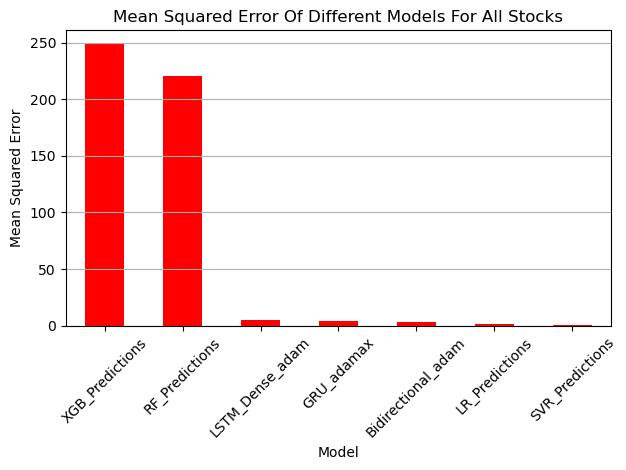

<Figure size 1500x600 with 0 Axes>

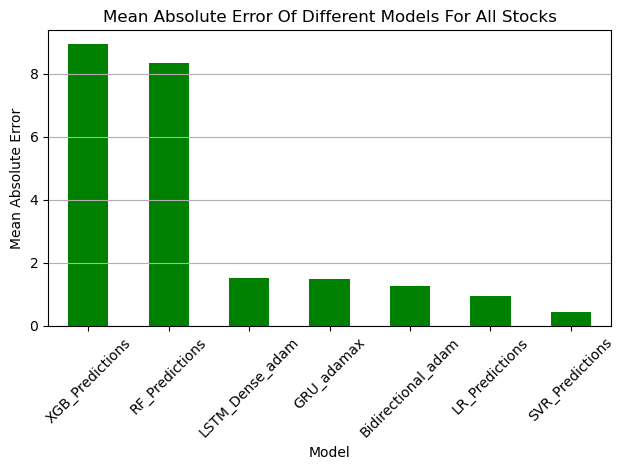

<Figure size 1500x600 with 0 Axes>

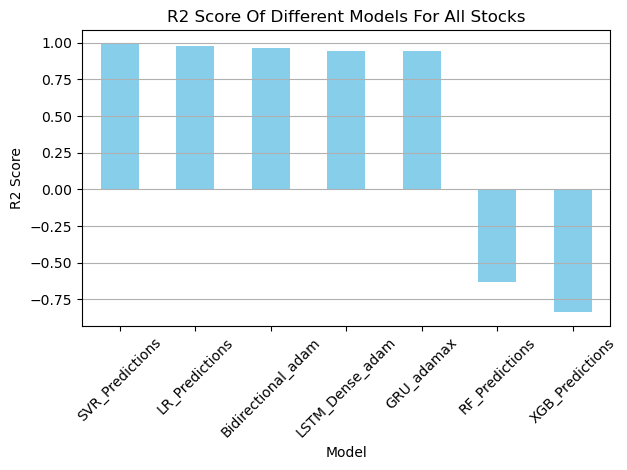

In [6]:
def plot_metric(metric_name,color):
    plt.figure(figsize=(15, 6))
    aggregate_results.sort_values(by=metric_name, ascending=False).plot(x='Model', y=metric_name, kind='bar', color=color, legend=False)
    plt.title(f"{metric_name} Of Different Models For All Stocks")
    plt.ylabel(metric_name)
    plt.xlabel('Model')
    plt.xticks(rotation=45)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

plot_metric('Mean Squared Error','red')
plot_metric('Mean Absolute Error','green')
plot_metric('R2 Score','skyblue')

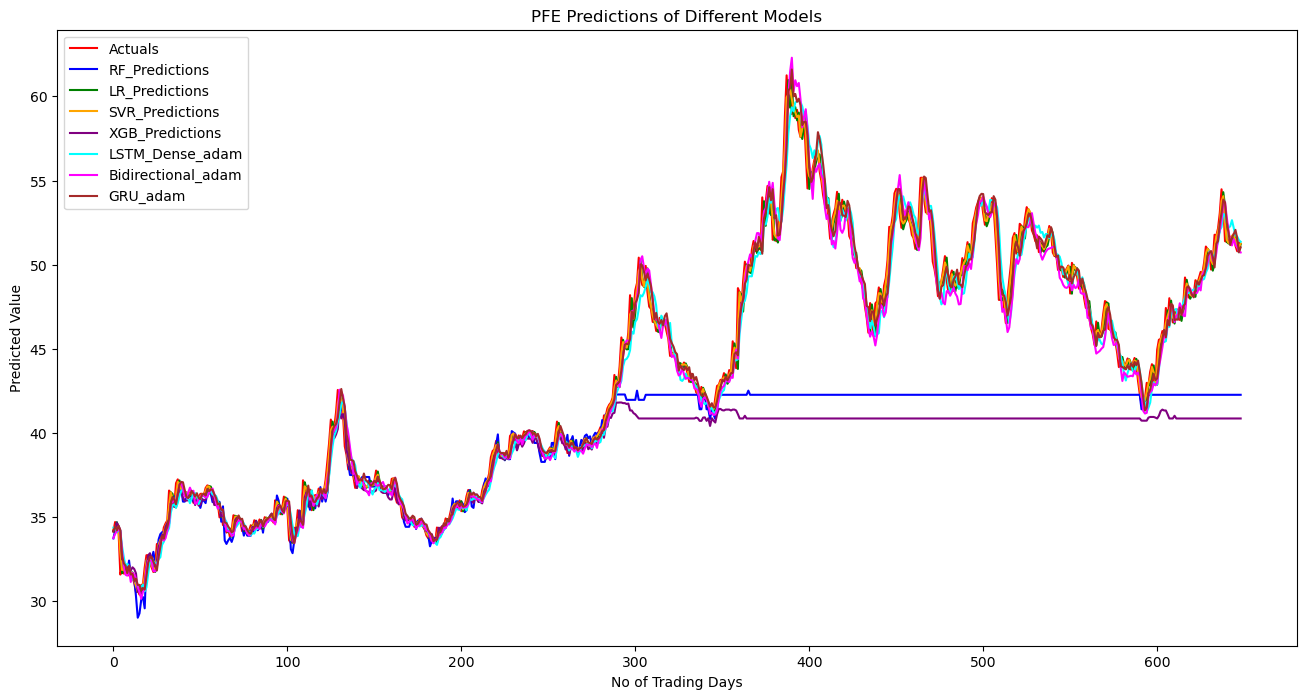

In [42]:
model_files = [
    'Actuals.csv',
    'RF_Predictions.csv',
    'LR_Predictions.csv',
    'SVR_Predictions.csv',
    'XGB_Predictions.csv',
    'LSTM_Dense_adam.csv',
    'Bidirectional_adam.csv',
    'GRU_adam.csv',
    
]

colors = {
    'Actuals': 'red',
    'RF_Predictions': 'blue',
    'LR_Predictions': 'green',
    'SVR_Predictions': 'orange',
    'XGB_Predictions': 'purple',
    'LSTM_Dense_adam': 'cyan',
    'Bidirectional_adam': 'magenta',
    'GRU_adam': 'brown'
}


# Initialize an empty DataFrame to hold PFE predictions from all models
merged_df = pd.DataFrame()

# Read each file, drop 'Unnamed: 0', filter for 'PFE', and merge
for model_file in model_files:
    # Read the CSV file
    df = pd.read_csv(f'C:/Users/kship/Documents/IB/predictions/results/{model_file}')
    
    # Drop the column 'Unnamed: 0'
    df = df.drop(columns=['Unnamed: 0'])
    
    # Filter for rows where the stock is 'PFE'
    pfe_data = df['PFE'].rename(model_file.split('.')[0])  # Remove the '.csv' from the model_file
    
    # Appending this to merged DataFrame
    if merged_df.empty:
        merged_df = pd.DataFrame(pfe_data).rename(columns={'ABT': model_file.split('.')[0]})
    else:
        merged_df[model_file.split('.')[0]] = pfe_data

# Plotting the line chart
plt.figure(figsize=(16, 8))
for column in merged_df.columns:
    plt.plot(merged_df.index, merged_df[column], label=column, color=colors[column])

plt.title('PFE Predictions of Different Models')
plt.xlabel('No of Trading Days')
plt.ylabel('Predicted Value')
plt.legend()
plt.show()

## Best model stock price prediction

In [28]:
act=pd.read_csv(f'C:/Users/kship/Documents/IB/predictions/results/Actuals.csv')
act.drop(columns=['Unnamed: 0'],inplace=True)
act

,ABT,IBM,ORCL,INTC,MO,NVS,PFE,TMUS,KO,XOM
0,89.860001,126.252388,53.980000,64.339996,41.910000,85.889999,34.146111,101.129997,49.090000,53.080002
1,92.559998,129.780121,55.099998,63.669998,42.830002,85.669998,34.715370,104.459999,49.849998,54.740002
2,90.269997,126.070747,54.180000,63.040001,42.180000,88.430000,34.354839,103.190002,49.000000,53.520000
3,92.160004,124.158699,54.110001,63.869999,41.820000,88.000000,34.079697,105.790001,48.619999,50.650002
4,87.779999,112.820267,51.310001,59.700001,39.290001,84.400002,31.593927,100.889999,45.540001,46.180000
...,...,...,...,...,...,...,...,...,...,...
644,108.180000,141.649994,80.849998,26.090000,46.240002,90.870003,51.830002,140.020004,63.820000,108.680000
645,108.570000,142.419998,80.980003,25.940001,46.480000,91.129997,51.130001,140.990005,64.209999,110.190002
646,107.830002,140.020004,80.330002,25.540001,45.849998,90.839996,50.799999,138.979996,63.570000,108.379997
647,110.309998,141.059998,81.400002,26.209999,45.869999,91.599998,51.330002,139.399994,63.950001,109.199997


In [31]:
stock=pd.read_csv(f'C:/Users/kship/Documents/IB/predictions/results/SVR_Predictions.csv')
stock.drop(columns=['Unnamed: 0'],inplace=True)
stock

,ABT,IBM,ORCL,INTC,MO,NVS,PFE,TMUS,KO,XOM
0,89.058984,125.490732,53.521995,63.542724,41.119684,85.488894,34.271847,100.588966,48.797737,52.584550
1,91.027003,128.827424,54.668077,63.832551,42.177982,85.721145,34.390539,101.915998,49.608479,54.549372
2,92.000985,127.169937,54.556866,63.385360,42.645195,86.953325,34.538406,103.760115,49.176588,53.651455
3,91.231276,124.813076,54.196193,63.589269,42.048838,88.164879,34.271255,103.781948,48.732081,50.982755
4,90.506216,116.144092,52.477799,61.487696,41.044751,86.252790,32.911660,104.026981,46.228745,46.711343
...,...,...,...,...,...,...,...,...,...,...
644,108.282645,141.472130,80.825892,26.158482,45.966298,90.849224,51.762196,140.106312,63.710813,108.343426
645,108.458159,142.193010,80.941533,26.041881,46.319766,90.930726,51.455452,140.280322,64.100170,110.006867
646,108.171576,140.739321,80.545114,25.772255,46.289069,91.001119,51.030462,140.841104,63.701065,108.612610
647,108.831488,140.675280,80.929802,25.929842,45.875962,91.172713,51.020602,139.205253,63.861943,109.096432


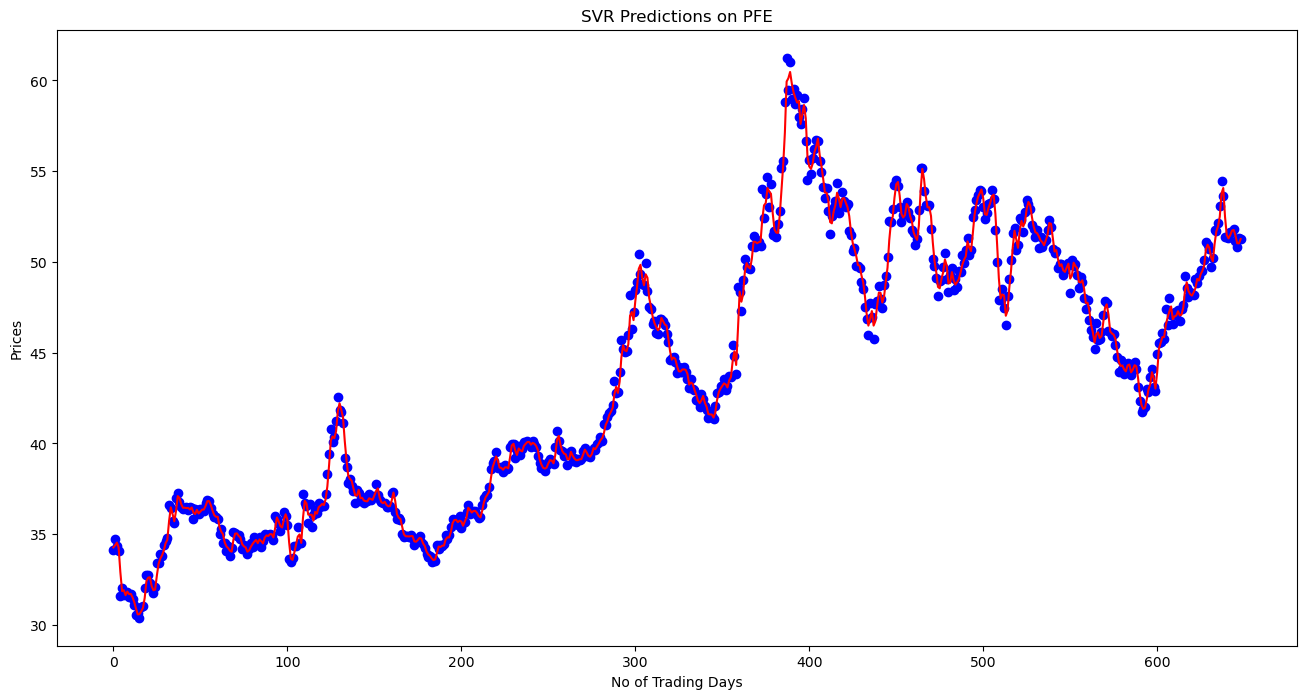

In [41]:
plt.figure(figsize=(16, 8))
plt.scatter(act.index,act['PFE'], color = 'blue')
plt.plot(stock.index,stock['PFE'], color = 'red')
plt.title('SVR Predictions on PFE')
plt.xlabel('No of Trading Days')
plt.ylabel('Prices')
plt.show()

## Portfolio Optimization on Stocks

In [1]:

model_files = [
    'RF_Predictions',
    'LR_Predictions',
    'SVR_Predictions',
    'XGB_Predictions',
    'LSTM_Dense_adam',
    'LSTM_Dense_rmsprop',
    'LSTM_Dense_adamax',
    'Bidirectional_adam',
    'Bidirectional_rmsprop',
    'Bidirectional_adamax',
    'GRU_adam',
    'GRU_rmsprop',
    'GRU_adamax'
    
]
def process_file(model_file):
# Main loop to read different prediction files
    print(f"Processing {model_file}")
    
    # Read stocks data and drop unnecessary columns
    stocks = pd.read_csv(f'C:/Users/kship/Documents/IB/predictions/results/{model_file}.csv')
    stocks.drop(columns=['Unnamed: 0'], inplace=True)
    

    assetLabels = stocks.columns.tolist()
    print('Asset labels of k-portfolio 1: \n', assetLabels)

    #read asset prices data
    StockData = stocks.iloc[0:, 0:]

    #compute asset returns
    arStockPrices = np.asarray(StockData)
    [Rows, Cols]=arStockPrices.shape
    arReturns = StockReturnsComputing(arStockPrices, Rows, Cols)

    #set precision for printing results
    np.set_printoptions(precision=3, suppress = True)

    #compute mean returns and variance covariance matrix of returns
    meanReturns = np.mean(arReturns, axis = 0)
    covReturns = np.cov(arReturns, rowvar=False)

    
    portfolioSize = len(stocks.columns)

    #set risk free asset rate of return
    Rf=3  # April 2019 average risk  free rate of return in USA approx 3%
    annRiskFreeRate = Rf/100

    #compute daily risk free rate in percentage
    r0 = (np.power((1 + annRiskFreeRate),  (1.0 / 360.0)) - 1.0) * 100 
    print('\nRisk free rate (daily %): ', end="")
    print ("{0:.3f}".format(r0)) 

    #initialization
    xOptimal =[]
    minRiskPoint = []
    expPortfolioReturnPoint =[]
    maxSharpeRatio = 0

    #compute maximal Sharpe Ratio and optimal weights
    result = MaximizeSharpeRatioOptmzn(meanReturns, covReturns, r0, portfolioSize)
    xOptimal.append(result.x)


    #compute risk returns and max Sharpe Ratio of the optimal portfolio   
    xOptimalArray = np.array(xOptimal)
    Risk = np.matmul((np.matmul(xOptimalArray,covReturns)), np.transpose(xOptimalArray))
    expReturn = np.matmul(np.array(meanReturns),xOptimalArray.T)
    annRisk =   np.sqrt(Risk*251) 
    annRet = 251*np.array(expReturn) 
    maxSharpeRatio = (annRet-Rf)/annRisk 

    #set precision for printing results
    np.set_printoptions(precision=3, suppress = True)

    #display results
    print('Maximal Sharpe Ratio: ', maxSharpeRatio, '\nAnnualized Risk (%):  ', \
          annRisk, '\nAnnualized Expected Portfolio Return(%):  ', annRet)
    print('\nOptimal weights (%):\n',  xOptimalArray.T*100 )
    
    non_zero_indices = np.where(xOptimalArray[0] > 1e-10)[0]  # Replace 1e-10 with an appropriate threshold if needed
    filtered_weights = xOptimalArray[0][non_zero_indices]
    filtered_labels = [assetLabels[i] for i in non_zero_indices]

#     #display results
    print('Maximal Sharpe Ratio: ', maxSharpeRatio, '\nAnnualized Risk (%):  ', \
          annRisk, '\nAnnualized Expected Portfolio Return(%):  ', annRet)
    print('\nOptimal weights (%):\n',  xOptimalArray.T*100 )

    # Plotting
    plt.figure(figsize=(8, 8))
    plt.pie(filtered_weights, labels=filtered_labels, autopct='%1.2f%%')
    plt.title('Optimal Asset Allocation')
    plt.show()

In [7]:
from ipywidgets import interactive, widgets
dropdown = widgets.Dropdown(
    options=model_files,
    description='Model File:',
)

# Use the interactive function to tie the dropdown to your process_file function
interactive_plot = interactive(process_file, model_file=dropdown)
interactive_plot





interactive(children=(Dropdown(description='Model File:', options=('RF_Predictions', 'LR_Predictions', 'SVR_Pr…

## Analyzing Return Risk for every model

In [99]:
annualized_returns = []
annualized_risks = []
sharpe_maximised=[]
m=[]
# results_df=pd.DataFrame()
model_files = [
    'RF_Predictions',
    'LR_Predictions',
    'SVR_Predictions',
    'XGB_Predictions',
    'LSTM_Dense_adam',
    'Bidirectional_adam',
    'GRU_adam',
    
]

for model_file in model_files:
# Main loop to read different prediction files
   
    # Read stocks data and drop unnecessary columns
    stock = pd.read_csv(f'C:/Users/kship/Documents/IB/predictions/results/{model_file}.csv')
    stock.drop(columns=['Unnamed: 0'], inplace=True)
  
    results = pd.DataFrame(columns=['Stock', 'Mean Squared Error', 'Mean Absolute Error', 'R2 Score'])

    # Loop through each stock and calculate the metrics
    for asset_name in stock.columns:
        mse = mean_squared_error(actuals[asset_name], stock[asset_name])
        mae = mean_absolute_error(actuals[asset_name], stock[asset_name])
        r2 = r2_score(actuals[asset_name], stock[asset_name])


        results = results.append({
            'Stock': asset_name,
            'Mean Squared Error': mse,
            'Mean Absolute Error': mae,
            'R2 Score': r2
        }, ignore_index=True)
    
    avg_mse = results['Mean Squared Error'].mean()
    avg_mae = results['Mean Absolute Error'].mean()
    avg_r2 = results['R2 Score'].mean()

    

    
    assetLabels = stock.columns.tolist()


    #read asset prices data
    StockData = stock.iloc[0:, 0:]

    #compute asset returns
    arStockPrices = np.asarray(StockData)
    [Rows, Cols]=arStockPrices.shape
    arReturns = StockReturnsComputing(arStockPrices, Rows, Cols)

    #set precision for printing results
    np.set_printoptions(precision=3, suppress = True)

    #compute mean returns and variance covariance matrix of returns
    meanReturns = np.mean(arReturns, axis = 0)
    covReturns = np.cov(arReturns, rowvar=False)
 


    portfolioSize = len(stock.columns)

    #set risk free asset rate of return
    Rf=3  # April 2019 average risk  free rate of return in USA approx 3%
    annRiskFreeRate = Rf/100

    #compute daily risk free rate in percentage
    r0 = (np.power((1 + annRiskFreeRate),  (1.0 / 360.0)) - 1.0) * 100 
#     print('\nRisk free rate (daily %): ', end="")
#     print ("{0:.3f}".format(r0)) 

    #initialization
    xOptimal =[]
    minRiskPoint = []
    expPortfolioReturnPoint =[]
    maxSharpeRatio = 0

    #compute maximal Sharpe Ratio and optimal weights
    result = MaximizeSharpeRatioOptmzn(meanReturns, covReturns, r0, portfolioSize)
    xOptimal.append(result.x)


    #compute risk returns and max Sharpe Ratio of the optimal portfolio   
    xOptimalArray = np.array(xOptimal)
    Risk = np.matmul((np.matmul(xOptimalArray,covReturns)), np.transpose(xOptimalArray))
    expReturn = np.matmul(np.array(meanReturns),xOptimalArray.T)
    annRisk =   np.sqrt(Risk*251) 
    annRet = 251*np.array(expReturn) 
    maxSharpeRatio = (annRet-Rf)/annRisk 

    #set precision for printing results
    np.set_printoptions(precision=3, suppress = True)
        # Append results to lists
    annualized_returns.append(float(annRet[0]))
    annualized_risks.append(float(annRisk[0][0]))
    sharpe_maximised.append(float(maxSharpeRatio[0]))
    m.append(avg_mse)
    # Create a dataframe with the results
    
pd.set_option('display.max_columns', None)  # Display all columns


results_df = pd.DataFrame({
        'Model': model_files,
        'Annualized Return (%)': annualized_returns,
        'Annualized Risk (%)': annualized_risks,
        'Sharpe Ratio': sharpe_maximised,
        'Mean Squared Error':m
})

    # Display the dataframe
results_df = results_df.round(3)

print(results_df)


                Model  Annualized Return (%)  Annualized Risk (%)  \
0      RF_Predictions                 18.017               17.297   
1      LR_Predictions                 22.460               17.112   
2     SVR_Predictions                 20.019               13.325   
3     XGB_Predictions                 16.503               14.868   
4     LSTM_Dense_adam                 21.148               11.232   
5  Bidirectional_adam                 22.397               12.476   
6            GRU_adam                 20.900               10.663   

   Sharpe Ratio  Mean Squared Error  
0         0.868             220.582  
1         1.137               1.939  
2         1.277               0.499  
3         0.908             248.376  
4         1.616               4.805  
5         1.555               3.387  
6         1.679               3.062  


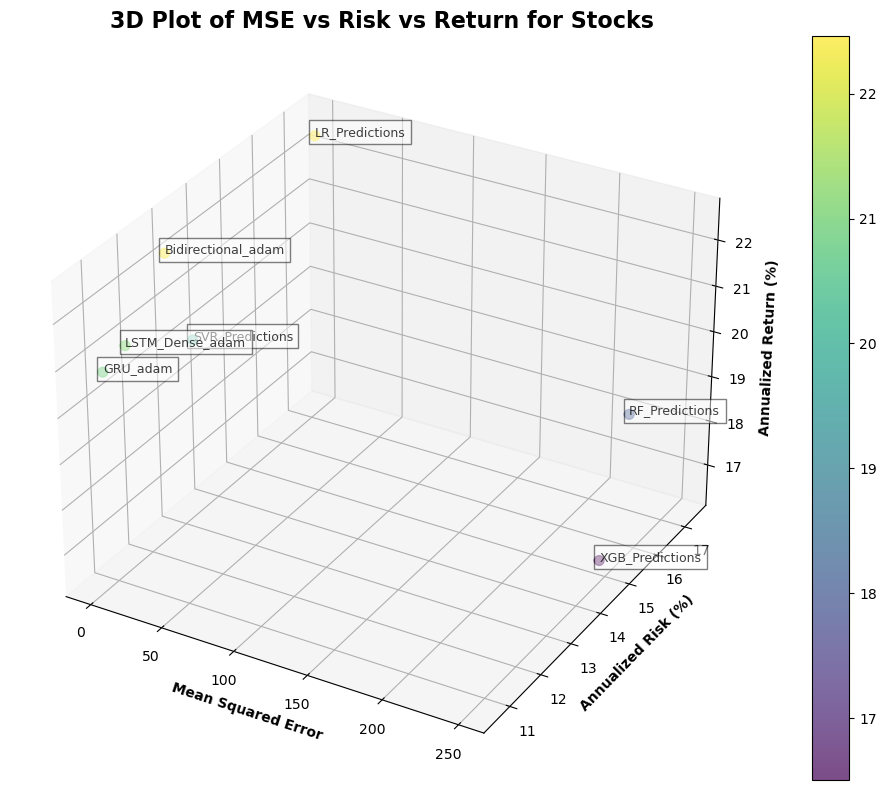

In [100]:

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot 
sc = ax.scatter(m, annualized_risks, annualized_returns, c=annualized_returns, cmap='viridis', s=50, alpha=0.7)
plt.colorbar(sc)


for i, model_name in enumerate(model_files):
    ax.text(m[i], annualized_risks[i], annualized_returns[i], model_name, fontsize=9, alpha=0.75, bbox=dict(facecolor='white', alpha=0.5))


ax.set_title('3D Plot of MSE vs Risk vs Return for Stocks', fontsize=16, fontweight='bold')
ax.set_xlabel('Mean Squared Error', fontweight='bold')
ax.set_ylabel('Annualized Risk (%)', fontweight='bold')
ax.set_zlabel('Annualized Return (%)', fontweight='bold')


ax.xaxis.pane.fill = True
ax.yaxis.pane.fill = True
ax.zaxis.pane.fill = True
ax.grid()

# Display the plot
plt.tight_layout()
plt.show()


# Commodities

In [14]:
actuals_C=pd.read_csv(f'C:/Users/kship/Documents/IB/predictions/results/LR_Actuals_C.csv')
actuals_C.drop(columns=['Unnamed: 0'], inplace=True)
actuals_C

,CL=F,BZ=F,NG=F,SI=F,HG=F,ZC=F,CT=F,LE=F,KC=F
0,39.549999,42.299999,1.782,17.443001,2.5570,331.25,61.790001,93.900002,98.900002
1,38.189999,40.799999,1.789,17.868000,2.5700,333.75,60.810001,94.125000,98.900002
2,38.939999,41.180000,1.767,17.774000,2.6005,327.50,60.520000,96.324997,97.800003
3,39.599998,41.730000,1.780,17.775999,2.6570,326.25,60.509998,96.599998,96.750000
4,36.340000,38.549999,1.813,17.868999,2.5865,329.75,60.020000,96.824997,96.000000
...,...,...,...,...,...,...,...,...,...
644,79.559998,83.919998,5.079,23.764000,3.8030,666.25,85.209999,156.899994,172.000000
645,79.529999,84.330002,5.282,24.040001,3.8335,674.75,84.239998,156.824997,166.949997
646,78.959999,83.260002,4.709,23.663000,3.8320,682.75,83.260002,157.449997,173.550003
647,78.400002,82.260002,4.559,24.077999,3.8210,679.50,82.639999,158.500000,170.050003


In [43]:
model_files = [
    'RF_Predictions',
    'LR_Predictions',
    'SVR_Predictions',
    'XGB_Predictions',
    'LSTM_Dense_adam',
    'Bidirectional_adam',
    'GRU_adamax'
    
]

aggregate_results = pd.DataFrame(columns=['Model', 'Mean Squared Error', 'Mean Absolute Error', 'R2 Score'])

for model_file in model_files:
    print(f"Processing {model_file}")

    com = pd.read_csv(f'C:/Users/kship/Documents/IB/predictions/results/{model_file}_C.csv')
    com.drop(columns=['Unnamed: 0'], inplace=True)
    
    results = pd.DataFrame(columns=['Stock', 'Mean Squared Error', 'Mean Absolute Error', 'R2 Score'])
    for asset_name in com.columns:
       
        mse = mean_squared_error(actuals_C[asset_name], com[asset_name])
        mae = mean_absolute_error(actuals_C[asset_name], com[asset_name])
        r2 = r2_score(actuals_C[asset_name], com[asset_name])

        results = results.append({
            'Stock': asset_name,
            'Mean Squared Error': mse,
            'Mean Absolute Error': mae,
            'R2 Score': r2
        }, ignore_index=True)
    
    avg_mse = results['Mean Squared Error'].mean()
    avg_mae = results['Mean Absolute Error'].mean()
    avg_r2 = results['R2 Score'].mean()

    aggregate_results = aggregate_results.append({
        'Model': model_file,
        'Mean Squared Error': avg_mse,
        'Mean Absolute Error': avg_mae,
        'R2 Score': avg_r2
    }, ignore_index=True)
    
print(aggregate_results)

Processing RF_Predictions
Processing LR_Predictions
Processing SVR_Predictions
Processing XGB_Predictions
Processing LSTM_Dense_adam
Processing Bidirectional_adam
Processing GRU_adamax
                Model  Mean Squared Error  Mean Absolute Error  R2 Score
0      RF_Predictions           27.993945             2.404086  0.944862
1      LR_Predictions           21.101985             1.886894  0.987021
2     SVR_Predictions            3.903832             0.704056  0.998877
3     XGB_Predictions           22.386413             2.144792  0.950920
4     LSTM_Dense_adam           27.329733             2.249179  0.979332
5  Bidirectional_adam           24.676832             2.109420  0.983550
6          GRU_adamax           34.451637             2.660549  0.980249


<Figure size 1500x600 with 0 Axes>

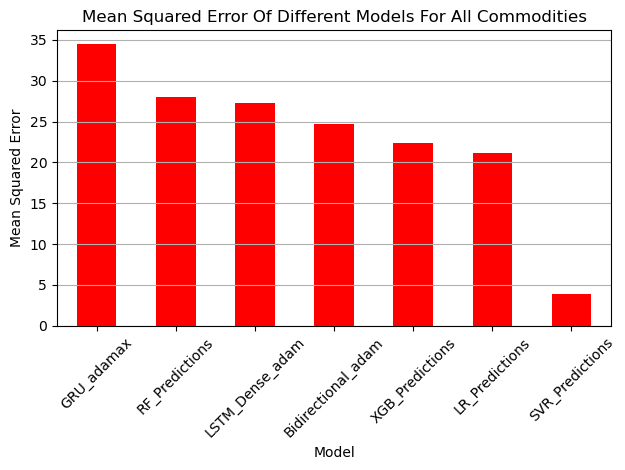

<Figure size 1500x600 with 0 Axes>

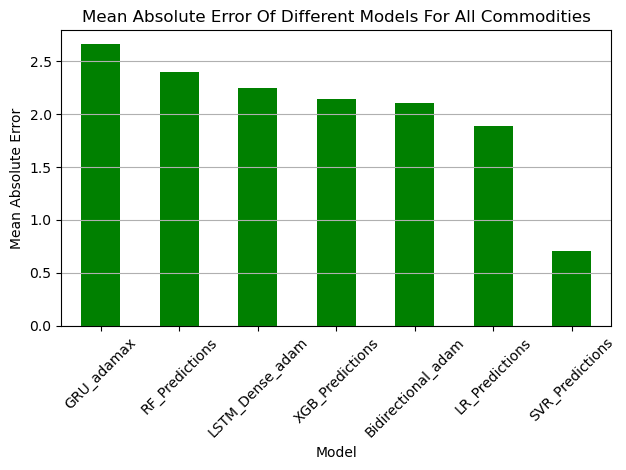

<Figure size 1500x600 with 0 Axes>

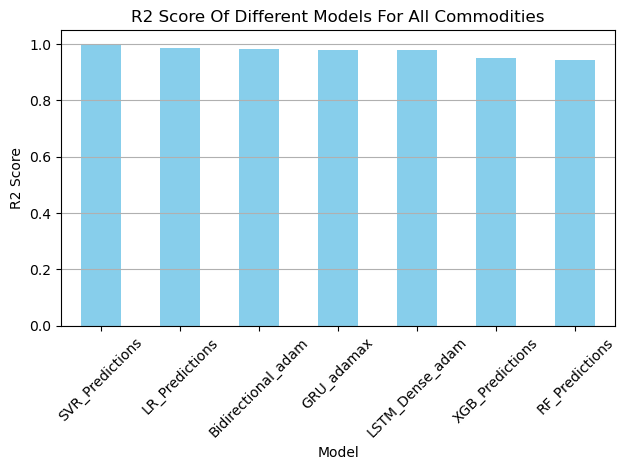

In [18]:
def plot_metric(metric_name,color):
    plt.figure(figsize=(15, 6))
    aggregate_results.sort_values(by=metric_name, ascending=False).plot(x='Model', y=metric_name, kind='bar', color=color, legend=False)
    plt.title(f"{metric_name} Of Different Models For All Commodities")
    plt.ylabel(metric_name)
    plt.xlabel('Model')
    plt.xticks(rotation=45)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

plot_metric('Mean Squared Error','red')
plot_metric('Mean Absolute Error','green')
plot_metric('R2 Score','skyblue')

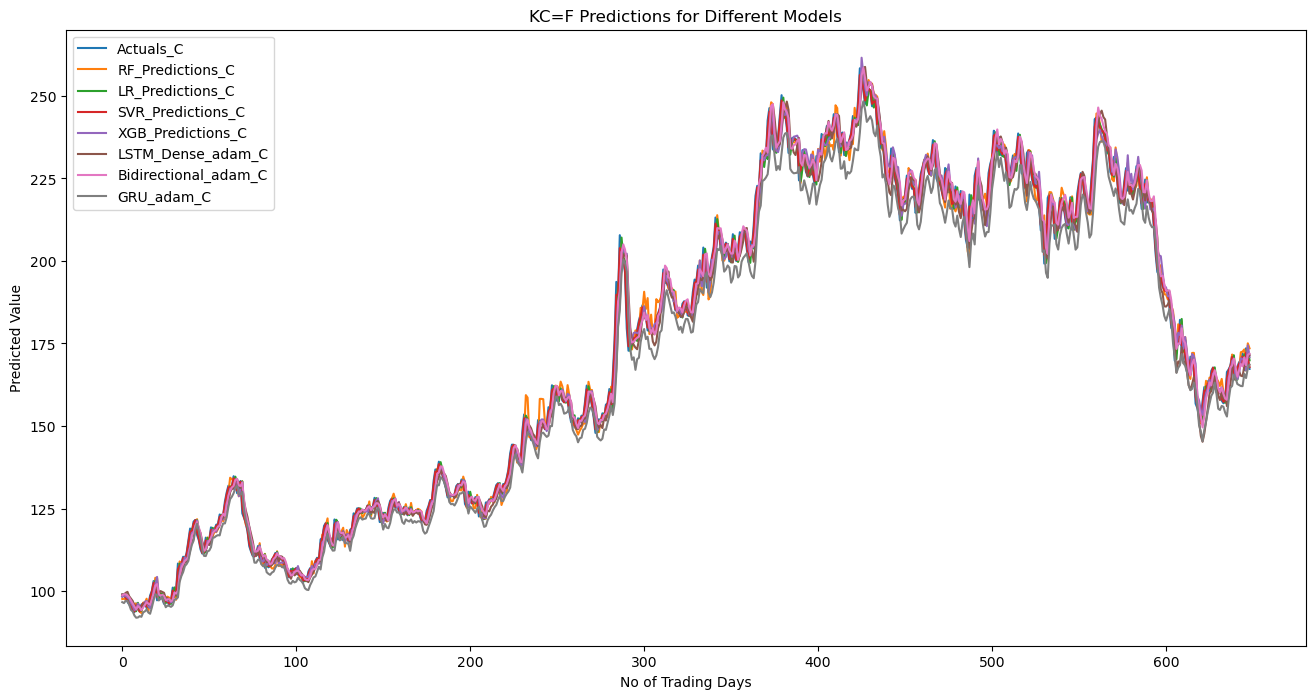

In [40]:
model_files = [
    'Actuals_C.csv',
    'RF_Predictions_C.csv',
    'LR_Predictions_C.csv',
    'SVR_Predictions_C.csv',
    'XGB_Predictions_C.csv',
    'LSTM_Dense_adam_C.csv',
    'Bidirectional_adam_C.csv',
    'GRU_adam_C.csv',
    
]



# Initialize an empty DataFrame to hold PFE predictions from all models
merged_df = pd.DataFrame()

# Read each file, drop 'Unnamed: 0', filter for 'PFE', and merge
for model_file in model_files:
    # Read the CSV file
    df = pd.read_csv(f'C:/Users/kship/Documents/IB/predictions/results/{model_file}')
    
    # Drop the column 'Unnamed: 0'
    df = df.drop(columns=['Unnamed: 0'])
    
    # Filter for rows where the stock is 'PFE'
    pfe_data = df['KC=F'].rename(model_file.split('.')[0])  # Remove the '.csv' from the model_file
    
    # Append this to our merged DataFrame
    if merged_df.empty:
        merged_df = pd.DataFrame(pfe_data).rename(columns={'KC=F': model_file.split('.')[0]})
    else:
        merged_df[model_file.split('.')[0]] = pfe_data

# Plotting the line chart
plt.figure(figsize=(16, 8))
for column in merged_df.columns:
    if column == 'Actuals':  # Mark the actual values with 'x'
        plt.plot(merged_df.index, merged_df[column], label=column, color='red')
    else:
        plt.plot(merged_df.index, merged_df[column], label=column)

plt.title('KC=F Predictions for Different Models')
plt.xlabel('No of Trading Days')
plt.ylabel('Predicted Value')
plt.legend()
plt.show()

## Best Prediction 

In [27]:
act_C=pd.read_csv(f'C:/Users/kship/Documents/IB/predictions/results/LR_Actuals_C.csv')
act_C.drop(columns=['Unnamed: 0'],inplace=True)
act_C

,CL=F,BZ=F,NG=F,SI=F,HG=F,ZC=F,CT=F,LE=F,KC=F
0,39.549999,42.299999,1.782,17.443001,2.5570,331.25,61.790001,93.900002,98.900002
1,38.189999,40.799999,1.789,17.868000,2.5700,333.75,60.810001,94.125000,98.900002
2,38.939999,41.180000,1.767,17.774000,2.6005,327.50,60.520000,96.324997,97.800003
3,39.599998,41.730000,1.780,17.775999,2.6570,326.25,60.509998,96.599998,96.750000
4,36.340000,38.549999,1.813,17.868999,2.5865,329.75,60.020000,96.824997,96.000000
...,...,...,...,...,...,...,...,...,...
644,79.559998,83.919998,5.079,23.764000,3.8030,666.25,85.209999,156.899994,172.000000
645,79.529999,84.330002,5.282,24.040001,3.8335,674.75,84.239998,156.824997,166.949997
646,78.959999,83.260002,4.709,23.663000,3.8320,682.75,83.260002,157.449997,173.550003
647,78.400002,82.260002,4.559,24.077999,3.8210,679.50,82.639999,158.500000,170.050003


In [30]:
com=pd.read_csv(f'C:/Users/kship/Documents/IB/predictions/results/SVR_Predictions_C.csv')
com.drop(columns=['Unnamed: 0'],inplace=True)
com

,CL=F,BZ=F,NG=F,SI=F,HG=F,ZC=F,CT=F,LE=F,KC=F
0,38.667048,41.132209,1.788115,17.550650,2.542385,330.194236,61.539006,94.214665,98.742444
1,38.964754,41.857742,1.791115,17.769518,2.565801,332.522575,61.035188,94.003359,98.898138
2,38.854336,41.136651,1.771152,17.782046,2.592639,330.162331,60.562547,96.094237,98.009320
3,39.445217,41.613747,1.778426,17.777852,2.644251,326.561453,60.538215,96.580069,96.998846
4,38.120805,40.589708,1.810697,17.849267,2.601838,328.222499,60.071223,96.863161,96.265605
...,...,...,...,...,...,...,...,...,...
644,78.548903,81.963794,5.060937,23.707775,3.793944,662.828700,84.926122,156.731069,171.027606
645,79.384750,83.890039,5.259008,23.970947,3.822560,670.927467,84.324686,156.857090,167.845376
646,79.206717,83.860631,4.782851,23.729774,3.830817,678.712908,83.419378,157.362313,172.192320
647,78.629308,82.935715,4.572794,24.000140,3.821392,680.682733,82.692410,158.361225,170.695944


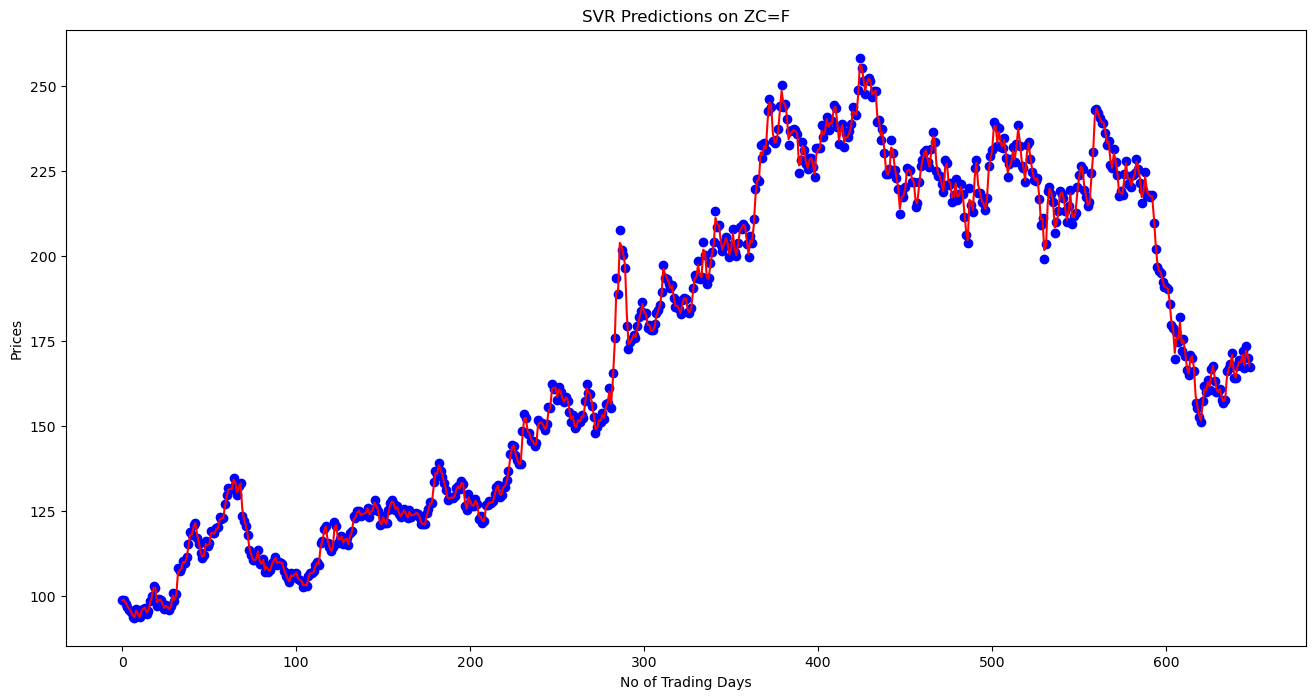

In [39]:
plt.figure(figsize=(16, 8))
plt.scatter(act_C.index,act_C['KC=F'], color = 'blue')
plt.plot(com.index,com['KC=F'], color = 'red')
plt.title('SVR Predictions on ZC=F')
plt.xlabel('No of Trading Days')
plt.ylabel('Prices')
plt.show()

## Portfolio Optimization on Commodities 

In [36]:

model_files = [
    'RF_Predictions',
    'LR_Predictions',
    'SVR_Predictions',
    'XGB_Predictions',
    'LSTM_Dense_adam',
    'LSTM_Dense_rmsprop',
    'LSTM_Dense_adamax',
    'Bidirectional_adam',
    'Bidirectional_rmsprop',
    'Bidirectional_adamax',
    'GRU_adam',
    'GRU_rmsprop',
    'GRU_adamax'
    
]
def process_file(model_file):
# Main loop to read different prediction files
    print(f"Processing {model_file}")
    
    # Read stocks data and drop unnecessary columns
    stocks = pd.read_csv(f'C:/Users/kship/Documents/IB/predictions/results/{model_file}_C.csv')
    stocks.drop(columns=['Unnamed: 0'], inplace=True)
    

    assetLabels = stocks.columns.tolist()
    print('Asset labels of k-portfolio 1: \n', assetLabels)

    #read asset prices data
    StockData = stocks.iloc[0:, 0:]

    #compute asset returns
    arStockPrices = np.asarray(StockData)
    [Rows, Cols]=arStockPrices.shape
    arReturns = StockReturnsComputing(arStockPrices, Rows, Cols)

    #set precision for printing results
    np.set_printoptions(precision=3, suppress = True)

    #compute mean returns and variance covariance matrix of returns
    meanReturns = np.mean(arReturns, axis = 0)
    covReturns = np.cov(arReturns, rowvar=False)
#     print('\nMean Returns:\n', meanReturns)
#     print('\nVariance-Covariance Matrix of Returns:\n', covReturns)

    
    portfolioSize = len(stocks.columns)

    #set risk free asset rate of return
    Rf=3  # April 2019 average risk  free rate of return in USA approx 3%
    annRiskFreeRate = Rf/100

    #compute daily risk free rate in percentage
    r0 = (np.power((1 + annRiskFreeRate),  (1.0 / 360.0)) - 1.0) * 100 
    print('\nRisk free rate (daily %): ', end="")
    print ("{0:.3f}".format(r0)) 

    #initialization
    xOptimal =[]
    minRiskPoint = []
    expPortfolioReturnPoint =[]
    maxSharpeRatio = 0

    #compute maximal Sharpe Ratio and optimal weights
    result = MaximizeSharpeRatioOptmzn(meanReturns, covReturns, r0, portfolioSize)
    xOptimal.append(result.x)


    #compute risk returns and max Sharpe Ratio of the optimal portfolio   
    xOptimalArray = np.array(xOptimal)
    Risk = np.matmul((np.matmul(xOptimalArray,covReturns)), np.transpose(xOptimalArray))
    expReturn = np.matmul(np.array(meanReturns),xOptimalArray.T)
    annRisk =   np.sqrt(Risk*251) 
    annRet = 251*np.array(expReturn) 
    maxSharpeRatio = (annRet-Rf)/annRisk 

    #set precision for printing results
    np.set_printoptions(precision=3, suppress = True)

    #display results
    print('Maximal Sharpe Ratio: ', maxSharpeRatio, '\nAnnualized Risk (%):  ', \
          annRisk, '\nAnnualized Expected Portfolio Return(%):  ', annRet)
    print('\nOptimal weights (%):\n',  xOptimalArray.T*100 )
    
    non_zero_indices = np.where(xOptimalArray[0] > 1e-10)[0]  # Replace 1e-10 with an appropriate threshold if needed
    filtered_weights = xOptimalArray[0][non_zero_indices]
    filtered_labels = [assetLabels[i] for i in non_zero_indices]

#     #display results
    print('Maximal Sharpe Ratio: ', maxSharpeRatio, '\nAnnualized Risk (%):  ', \
          annRisk, '\nAnnualized Expected Portfolio Return(%):  ', annRet)
    print('\nOptimal weights (%):\n',  xOptimalArray.T*100 )

    # Plotting
    plt.figure(figsize=(8, 8))
    plt.pie(filtered_weights, labels=filtered_labels, autopct='%1.2f%%')
    plt.title('Optimal Asset Allocation')
    plt.show()

In [37]:
from ipywidgets import interactive, widgets
dropdown = widgets.Dropdown(
    options=model_files,
    description='Model File:',
)

# Use the interactive function to tie the dropdown to your process_file function
interactive_plot = interactive(process_file, model_file=dropdown)
interactive_plot




interactive(children=(Dropdown(description='Model File:', options=('RF_Predictions', 'LR_Predictions', 'SVR_Pr…

In [97]:
annualized_returns = []
annualized_risks = []
sharpe_maximised=[]
m=[]
# results_df=pd.DataFrame()
model_files = [
    'RF_Predictions',
    'LR_Predictions',
    'SVR_Predictions',
    'XGB_Predictions',
    'LSTM_Dense_adam',
    'Bidirectional_adam',
    'GRU_adamax'
    
]

for model_file in model_files:
# Main loop to read different prediction files
   
    # Read stocks data and drop unnecessary columns
    com = pd.read_csv(f'C:/Users/kship/Documents/IB/predictions/results/{model_file}_C.csv')
    com.drop(columns=['Unnamed: 0'], inplace=True)
   
  
    results = pd.DataFrame(columns=['Stock', 'Mean Squared Error', 'Mean Absolute Error', 'R2 Score'])

    # Loop through each stock and calculate the metrics
    for asset_name in com.columns:
        mse = mean_squared_error(actuals_C[asset_name], com[asset_name])
        mae = mean_absolute_error(actuals_C[asset_name], com[asset_name])
        r2 = r2_score(actuals_C[asset_name], com[asset_name])


    results = results.append({
            'Stock': asset_name,
            'Mean Squared Error': mse,
            'Mean Absolute Error': mae,
            'R2 Score': r2
        }, ignore_index=True)
    
    avg_mse = results['Mean Squared Error'].mean()
    avg_mae = results['Mean Absolute Error'].mean()
    avg_r2 = results['R2 Score'].mean()


    assetLabels = com.columns.tolist()
#     print('Asset labels of k-portfolio 1: \n', assetLabels)

    #read asset prices data
    StockData = com.iloc[0:, 0:]

    #compute asset returns
    arStockPrices = np.asarray(StockData)
    [Rows, Cols]=arStockPrices.shape
    arReturns = StockReturnsComputing(arStockPrices, Rows, Cols)

    #set precision for printing results
    np.set_printoptions(precision=3, suppress = True)

    #compute mean returns and variance covariance matrix of returns
    meanReturns = np.mean(arReturns, axis = 0)
    covReturns = np.cov(arReturns, rowvar=False)
#     print('\nMean Returns:\n', meanReturns)
#     print('\nVariance-Covariance Matrix of Returns:\n', covReturns)


    


    portfolioSize = len(com.columns)

    #set risk free asset rate of return
    Rf=3  # April 2019 average risk  free rate of return in USA approx 3%
    annRiskFreeRate = Rf/100

    #compute daily risk free rate in percentage
    r0 = (np.power((1 + annRiskFreeRate),  (1.0 / 360.0)) - 1.0) * 100 

    #initialization
    xOptimal =[]
    minRiskPoint = []
    expPortfolioReturnPoint =[]
    maxSharpeRatio = 0

    #compute maximal Sharpe Ratio and optimal weights
    result = MaximizeSharpeRatioOptmzn(meanReturns, covReturns, r0, portfolioSize)
    xOptimal.append(result.x)


    #compute risk returns and max Sharpe Ratio of the optimal portfolio   
    xOptimalArray = np.array(xOptimal)
    Risk = np.matmul((np.matmul(xOptimalArray,covReturns)), np.transpose(xOptimalArray))
    expReturn = np.matmul(np.array(meanReturns),xOptimalArray.T)
    annRisk =   np.sqrt(Risk*251) 
    annRet = 251*np.array(expReturn) 
    maxSharpeRatio = (annRet-Rf)/annRisk 

    #set precision for printing results
    np.set_printoptions(precision=3, suppress = True)
        # Append results to lists
    annualized_returns.append(float(annRet[0]))
    annualized_risks.append(float(annRisk[0][0]))
    sharpe_maximised.append(float(maxSharpeRatio[0]))
    m.append(avg_mse)
    # Create a dataframe with the results
    
pd.set_option('display.max_columns', None)  # Display all columns


results_df = pd.DataFrame({
        'Model': model_files,
        'Annualized Return (%)': annualized_returns,
        'Annualized Risk (%)': annualized_risks,
        'Sharpe Ratio': sharpe_maximised,
        'Mean Squared Error':m
})

    # Display the dataframe
results_df = results_df.round(3)

print(results_df)


                Model  Annualized Return (%)  Annualized Risk (%)  \
0      RF_Predictions                 29.307               14.552   
1      LR_Predictions                 26.928               12.664   
2     SVR_Predictions                 25.674               10.729   
3     XGB_Predictions                 28.840               15.312   
4     LSTM_Dense_adam                 26.136                9.247   
5  Bidirectional_adam                 26.236               10.310   
6          GRU_adamax                 23.577                6.940   

   Sharpe Ratio  Mean Squared Error  
0         1.808              20.795  
1         1.889              16.691  
2         2.113               0.786  
3         1.688              20.541  
4         2.502              26.082  
5         2.254              20.613  
6         2.965              29.200  


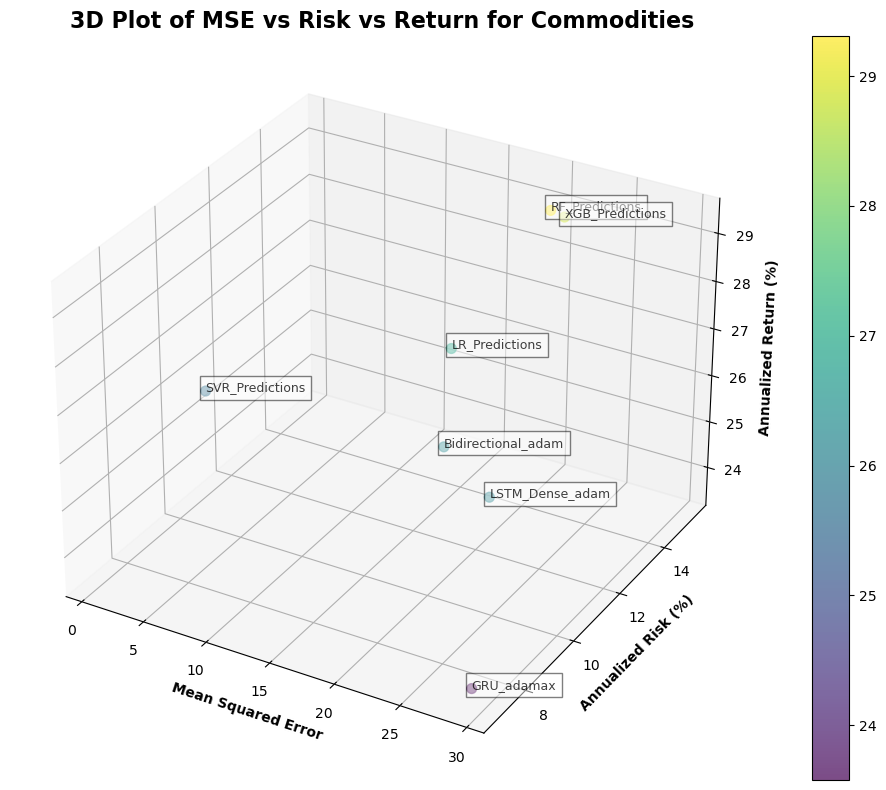

In [98]:

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot with adjusted point size and transparency
sc = ax.scatter(m, annualized_risks, annualized_returns, c=annualized_returns, cmap='viridis', s=50, alpha=0.7)
plt.colorbar(sc)

# Enhanced annotations with background color
for i, model_name in enumerate(model_files):
    ax.text(m[i], annualized_risks[i], annualized_returns[i], model_name, fontsize=9, alpha=0.75, bbox=dict(facecolor='white', alpha=0.5))

# Enhanced Titles and labels
ax.set_title('3D Plot of MSE vs Risk vs Return for Commodities', fontsize=16, fontweight='bold')
ax.set_xlabel('Mean Squared Error', fontweight='bold')
ax.set_ylabel('Annualized Risk (%)', fontweight='bold')
ax.set_zlabel('Annualized Return (%)', fontweight='bold')

# Adjusting background and grid
ax.xaxis.pane.fill = True
ax.yaxis.pane.fill = True
ax.zaxis.pane.fill = True
ax.grid()

# Display the plot
plt.tight_layout()
plt.show()


# Combined Portfolio Optimization

In [82]:

model_files = [
    'RF_Predictions',
    'LR_Predictions',
    'SVR_Predictions',
    'XGB_Predictions',
    'LSTM_Dense_adam',
    'LSTM_Dense_rmsprop',
    'LSTM_Dense_adamax',
    'Bidirectional_adam',
    'Bidirectional_rmsprop',
    'Bidirectional_adamax',
    'GRU_adam',
    'GRU_rmsprop',
    'GRU_adamax',
    'Actuals'
    
]
def process_file(model_file):
# Main loop to read different prediction files
    print(f"Processing {model_file}")
    
    # Read stocks data and drop unnecessary columns
    stocks = pd.read_csv(f'C:/Users/kship/Documents/IB/predictions/results/{model_file}.csv')
    stocks.drop(columns=['Unnamed: 0'], inplace=True)
    
    com=pd.read_csv(f'C:/Users/kship/Documents/IB/predictions/results/{model_file}_C.csv')
    com.drop(columns=['Unnamed: 0'],inplace=True)

    combined = pd.concat([stocks, com], axis=1)
    combined.dropna(axis=0,inplace=True)
    
    assetLabels = combined.columns.tolist()
    print('Asset labels of k-portfolio 1: \n', assetLabels)

    #read asset prices data
    StockData = combined.iloc[0:, 0:]

    #compute asset returns
    arStockPrices = np.asarray(StockData)
    [Rows, Cols]=arStockPrices.shape
    arReturns = StockReturnsComputing(arStockPrices, Rows, Cols)

    #set precision for printing results
    np.set_printoptions(precision=3, suppress = True)

    #compute mean returns and variance covariance matrix of returns
    meanReturns = np.mean(arReturns, axis = 0)
    covReturns = np.cov(arReturns, rowvar=False)
#     print('\nMean Returns:\n', meanReturns)
#     print('\nVariance-Covariance Matrix of Returns:\n', covReturns)

    
    portfolioSize = len(combined.columns)

    #set risk free asset rate of return
    Rf=3  # April 2019 average risk  free rate of return in USA approx 3%
    annRiskFreeRate = Rf/100

    #compute daily risk free rate in percentage
    r0 = (np.power((1 + annRiskFreeRate),  (1.0 / 360.0)) - 1.0) * 100 
    print('\nRisk free rate (daily %): ', end="")
    print ("{0:.3f}".format(r0)) 

    #initialization
    xOptimal =[]
    minRiskPoint = []
    expPortfolioReturnPoint =[]
    maxSharpeRatio = 0

    #compute maximal Sharpe Ratio and optimal weights
    result = MaximizeSharpeRatioOptmzn(meanReturns, covReturns, r0, portfolioSize)
    xOptimal.append(result.x)


    #compute risk returns and max Sharpe Ratio of the optimal portfolio   
    xOptimalArray = np.array(xOptimal)
    Risk = np.matmul((np.matmul(xOptimalArray,covReturns)), np.transpose(xOptimalArray))
    expReturn = np.matmul(np.array(meanReturns),xOptimalArray.T)
    annRisk =   np.sqrt(Risk*251) 
    annRet = 251*np.array(expReturn) 
    maxSharpeRatio = (annRet-Rf)/annRisk 

    #set precision for printing results
    np.set_printoptions(precision=3, suppress = True)

    #display results
    print('Maximal Sharpe Ratio: ', maxSharpeRatio, '\nAnnualized Risk (%):  ', \
          annRisk, '\nAnnualized Expected Portfolio Return(%):  ', annRet)
    print('\nOptimal weights (%):\n',  xOptimalArray.T*100 )
    
    non_zero_indices = np.where(xOptimalArray[0] > 1e-10)[0]  # Replace 1e-10 with an appropriate threshold if needed
    filtered_weights = xOptimalArray[0][non_zero_indices]
    filtered_labels = [assetLabels[i] for i in non_zero_indices]


    # Plotting
    plt.figure(figsize=(8, 8))
    plt.pie(filtered_weights, labels=filtered_labels, autopct='%1.2f%%')
    plt.title('Optimal Asset Allocation')
    plt.show()

In [83]:
from ipywidgets import interactive, widgets
dropdown = widgets.Dropdown(
    options=model_files,
    description='Model File:',
)

# Use the interactive function to tie the dropdown to your process_file function
interactive_plot = interactive(process_file, model_file=dropdown)
interactive_plot




interactive(children=(Dropdown(description='Model File:', options=('RF_Predictions', 'LR_Predictions', 'SVR_Pr…

In [64]:
actual_combined = pd.concat([actuals, actuals_C], axis=1)
actual_combined.dropna(axis=0,inplace=True)
actual_combined

,ABT,IBM,ORCL,INTC,MO,NVS,PFE,TMUS,KO,XOM,CL=F,BZ=F,NG=F,SI=F,HG=F,ZC=F,CT=F,LE=F,KC=F
0,89.860001,126.252388,53.980000,64.339996,41.910000,85.889999,34.146111,101.129997,49.090000,53.080002,39.549999,42.299999,1.782,17.443001,2.5570,331.25,61.790001,93.900002,98.900002
1,92.559998,129.780121,55.099998,63.669998,42.830002,85.669998,34.715370,104.459999,49.849998,54.740002,38.189999,40.799999,1.789,17.868000,2.5700,333.75,60.810001,94.125000,98.900002
2,90.269997,126.070747,54.180000,63.040001,42.180000,88.430000,34.354839,103.190002,49.000000,53.520000,38.939999,41.180000,1.767,17.774000,2.6005,327.50,60.520000,96.324997,97.800003
3,92.160004,124.158699,54.110001,63.869999,41.820000,88.000000,34.079697,105.790001,48.619999,50.650002,39.599998,41.730000,1.780,17.775999,2.6570,326.25,60.509998,96.599998,96.750000
4,87.779999,112.820267,51.310001,59.700001,39.290001,84.400002,31.593927,100.889999,45.540001,46.180000,36.340000,38.549999,1.813,17.868999,2.5865,329.75,60.020000,96.824997,96.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
644,108.180000,141.649994,80.849998,26.090000,46.240002,90.870003,51.830002,140.020004,63.820000,108.680000,79.559998,83.919998,5.079,23.764000,3.8030,666.25,85.209999,156.899994,172.000000
645,108.570000,142.419998,80.980003,25.940001,46.480000,91.129997,51.130001,140.990005,64.209999,110.190002,79.529999,84.330002,5.282,24.040001,3.8335,674.75,84.239998,156.824997,166.949997
646,107.830002,140.020004,80.330002,25.540001,45.849998,90.839996,50.799999,138.979996,63.570000,108.379997,78.959999,83.260002,4.709,23.663000,3.8320,682.75,83.260002,157.449997,173.550003
647,110.309998,141.059998,81.400002,26.209999,45.869999,91.599998,51.330002,139.399994,63.950001,109.199997,78.400002,82.260002,4.559,24.077999,3.8210,679.50,82.639999,158.500000,170.050003


In [101]:
annualized_returns = []
annualized_risks = []
sharpe_maximised=[]
m=[]


model_files = [
    'RF_Predictions',
    'LR_Predictions',
    'SVR_Predictions',
    'XGB_Predictions',
    'LSTM_Dense_adam',
    'Bidirectional_adam',
    'GRU_adam',
    'GRU_adamax'
    
]
for model_file in model_files:
# Main loop to read different prediction files
    print(f"Processing {model_file}")
    
    # Read stocks data and drop unnecessary columns
    stocks = pd.read_csv(f'C:/Users/kship/Documents/IB/predictions/results/{model_file}.csv')
    stocks.drop(columns=['Unnamed: 0'], inplace=True)
    
    com=pd.read_csv(f'C:/Users/kship/Documents/IB/predictions/results/{model_file}_C.csv')
    com.drop(columns=['Unnamed: 0'],inplace=True)

    combined = pd.concat([stocks, com], axis=1)
    combined.dropna(axis=0,inplace=True)

    
    results = pd.DataFrame(columns=['Stock', 'Mean Squared Error', 'Mean Absolute Error', 'R2 Score'])

#     # Loop through each stock and calculate the metrics
    for asset_name in com.columns:
        mse = mean_squared_error(actual_combined[asset_name], combined[asset_name])
        mae = mean_absolute_error(actual_combined[asset_name], combined[asset_name])
        r2 = r2_score(actual_combined[asset_name], combined[asset_name])

        results = results.append({
            'Stock': asset_name,
            'Mean Squared Error': mse,
            'Mean Absolute Error': mae,
            'R2 Score': r2
        }, ignore_index=True)
    
    avg_mse = results['Mean Squared Error'].mean()
    avg_mae = results['Mean Absolute Error'].mean()
    avg_r2 = results['R2 Score'].mean()

    
    assetLabels = combined.columns.tolist()


    #read asset prices data
    StockData = combined.iloc[0:, 0:]

    #compute asset returns
    arStockPrices = np.asarray(StockData)
    [Rows, Cols]=arStockPrices.shape
    arReturns = StockReturnsComputing(arStockPrices, Rows, Cols)

    #set precision for printing results
    np.set_printoptions(precision=3, suppress = True)

    #compute mean returns and variance covariance matrix of returns
    meanReturns = np.mean(arReturns, axis = 0)
    covReturns = np.cov(arReturns, rowvar=False)
#     print('\nMean Returns:\n', meanReturns)
#     print('\nVariance-Covariance Matrix of Returns:\n', covReturns)

    
    portfolioSize = len(combined.columns)

    #set risk free asset rate of return
    Rf=3  # April 2019 average risk  free rate of return in USA approx 3%
    annRiskFreeRate = Rf/100

    #compute daily risk free rate in percentage
    r0 = (np.power((1 + annRiskFreeRate),  (1.0 / 360.0)) - 1.0) * 100 

    #initialization
    xOptimal =[]
    minRiskPoint = []
    expPortfolioReturnPoint =[]
    maxSharpeRatio = 0

    #compute maximal Sharpe Ratio and optimal weights
    result = MaximizeSharpeRatioOptmzn(meanReturns, covReturns, r0, portfolioSize)
    xOptimal.append(result.x)


    #compute risk returns and max Sharpe Ratio of the optimal portfolio   
    xOptimalArray = np.array(xOptimal)
    Risk = np.matmul((np.matmul(xOptimalArray,covReturns)), np.transpose(xOptimalArray))
    expReturn = np.matmul(np.array(meanReturns),xOptimalArray.T)
    annRisk =   np.sqrt(Risk*251) 
    annRet = 251*np.array(expReturn) 
    maxSharpeRatio = (annRet-Rf)/annRisk 

    #set precision for printing results
    np.set_printoptions(precision=3, suppress = True)

    annualized_returns.append(float(annRet[0]))
    annualized_risks.append(float(annRisk[0][0]))
    sharpe_maximised.append(float(maxSharpeRatio[0]))
    m.append(avg_mse)
    # Create a dataframe with the results
    
pd.set_option('display.max_columns', None)  # Display all columns


results_df = pd.DataFrame({
        'Model': model_files,
        'Annualized Return (%)': annualized_returns,
        'Annualized Risk (%)': annualized_risks,
        'Sharpe Ratio': sharpe_maximised,
        'Mean Squared Error':m
})

    # Display the dataframe
results_df = results_df.round(3)



print(results_df)

Processing RF_Predictions
Processing LR_Predictions
Processing SVR_Predictions
Processing XGB_Predictions
Processing LSTM_Dense_adam
Processing Bidirectional_adam
Processing GRU_adam
Processing GRU_adamax
                Model  Annualized Return (%)  Annualized Risk (%)  \
0      RF_Predictions                 25.332               11.688   
1      LR_Predictions                 25.596               10.960   
2     SVR_Predictions                 24.197                9.180   
3     XGB_Predictions                 24.409               10.288   
4     LSTM_Dense_adam                 24.126                7.600   
5  Bidirectional_adam                 23.839                8.381   
6            GRU_adam                 23.195                7.578   
7          GRU_adamax                 23.197                5.908   

   Sharpe Ratio  Mean Squared Error  
0         1.911              27.994  
1         2.062              21.102  
2         2.309               3.904  
3         2.081      

In [95]:
results_df.to_csv('3d risk return.csv')

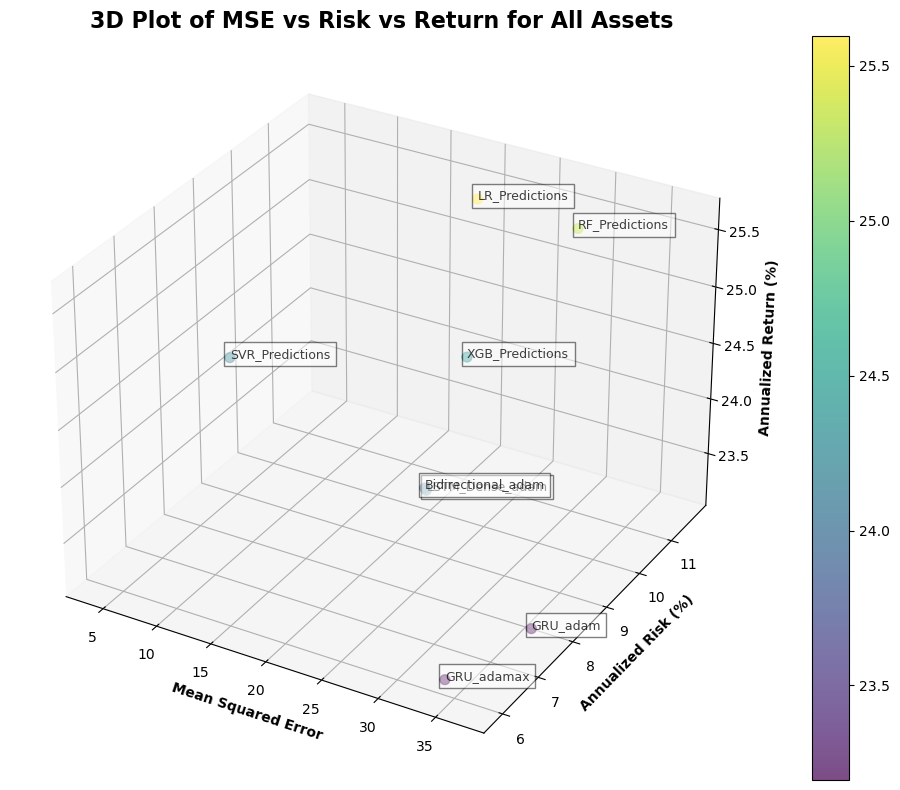

In [102]:

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot with adjusted point size and transparency
sc = ax.scatter(m, annualized_risks, annualized_returns, c=annualized_returns, cmap='viridis', s=50, alpha=0.7)
plt.colorbar(sc)

# Enhanced annotations with background color
for i, model_name in enumerate(model_files):
    ax.text(m[i], annualized_risks[i], annualized_returns[i], model_name, fontsize=9, alpha=0.75, bbox=dict(facecolor='white', alpha=0.5))

# Enhanced Titles and labels
ax.set_title('3D Plot of MSE vs Risk vs Return for All Assets', fontsize=16, fontweight='bold')
ax.set_xlabel('Mean Squared Error', fontweight='bold')
ax.set_ylabel('Annualized Risk (%)', fontweight='bold')
ax.set_zlabel('Annualized Return (%)', fontweight='bold')

# Adjusting background and grid
ax.xaxis.pane.fill = True
ax.yaxis.pane.fill = True
ax.zaxis.pane.fill = True
ax.grid()

# Display the plot
plt.tight_layout()
plt.show()


# SVR Portfolio Optimization

In [112]:
annualized_returns = []
annualized_risks = []
sharpe_maximised=[]




# Read stocks, commodities data and drop unnecessary columns
stocks = pd.read_csv(f'C:/Users/kship/Documents/IB/predictions/results/SVR_Predictions.csv')
stocks.drop(columns=['Unnamed: 0'], inplace=True)

com=pd.read_csv(f'C:/Users/kship/Documents/IB/predictions/results/SVR_Predictions_C.csv')
com.drop(columns=['Unnamed: 0'],inplace=True)

combined = pd.concat([stocks, com], axis=1)
combined.dropna(axis=0,inplace=True)

dataframes = {
    'stocks': stocks,
    'com': com,
    'combined': combined
}

models = ['SVR_stock', 'SVR_commodities', 'SVR_combined']

for asset_name, dataframe in dataframes.items():
    assetLabels = dataframe.columns.tolist()

    #read asset prices data
    StockData = dataframe.iloc[0:, 0:]

    #compute asset returns
    arStockPrices = np.asarray(StockData)
    [Rows, Cols]=arStockPrices.shape
    arReturns = StockReturnsComputing(arStockPrices, Rows, Cols)

    #set precision for printing results
    np.set_printoptions(precision=3, suppress = True)

    #compute mean returns and variance covariance matrix of returns
    meanReturns = np.mean(arReturns, axis = 0)
    covReturns = np.cov(arReturns, rowvar=False)


    portfolioSize = len(dataframe.columns)

    #set risk free asset rate of return
    Rf=3  # April 2019 average risk  free rate of return in USA approx 3%
    annRiskFreeRate = Rf/100

    #compute daily risk free rate in percentage
    r0 = (np.power((1 + annRiskFreeRate),  (1.0 / 360.0)) - 1.0) * 100 

    #initialization
    xOptimal =[]
    minRiskPoint = []
    expPortfolioReturnPoint =[]
    maxSharpeRatio = 0

    #compute maximal Sharpe Ratio and optimal weights
    result = MaximizeSharpeRatioOptmzn(meanReturns, covReturns, r0, portfolioSize)
    xOptimal.append(result.x)


    #compute risk returns and max Sharpe Ratio of the optimal portfolio   
    xOptimalArray = np.array(xOptimal)
    Risk = np.matmul((np.matmul(xOptimalArray,covReturns)), np.transpose(xOptimalArray))
    expReturn = np.matmul(np.array(meanReturns),xOptimalArray.T)
    annRisk =   np.sqrt(Risk*251) 
    annRet = 251*np.array(expReturn) 
    maxSharpeRatio = (annRet-Rf)/annRisk 

    #set precision for printing results
    np.set_printoptions(precision=3, suppress = True)

    annualized_returns.append(float(annRet[0]))
    annualized_risks.append(float(annRisk[0][0]))

    # Create a dataframe with the results
    
pd.set_option('display.max_columns', None)  # Display all columns


results_df = pd.DataFrame({
        'Model': models,
        'Annualized Return (%)': annualized_returns,
        'Annualized Risk (%)': annualized_risks,
      
})

    # Display the dataframe
results_df = results_df.round(3)



print(results_df)

             Model  Annualized Return (%)  Annualized Risk (%)
0        SVR_stock                 20.019               13.325
1  SVR_commodities                 25.674               10.729
2     SVR_combined                 24.197                9.180


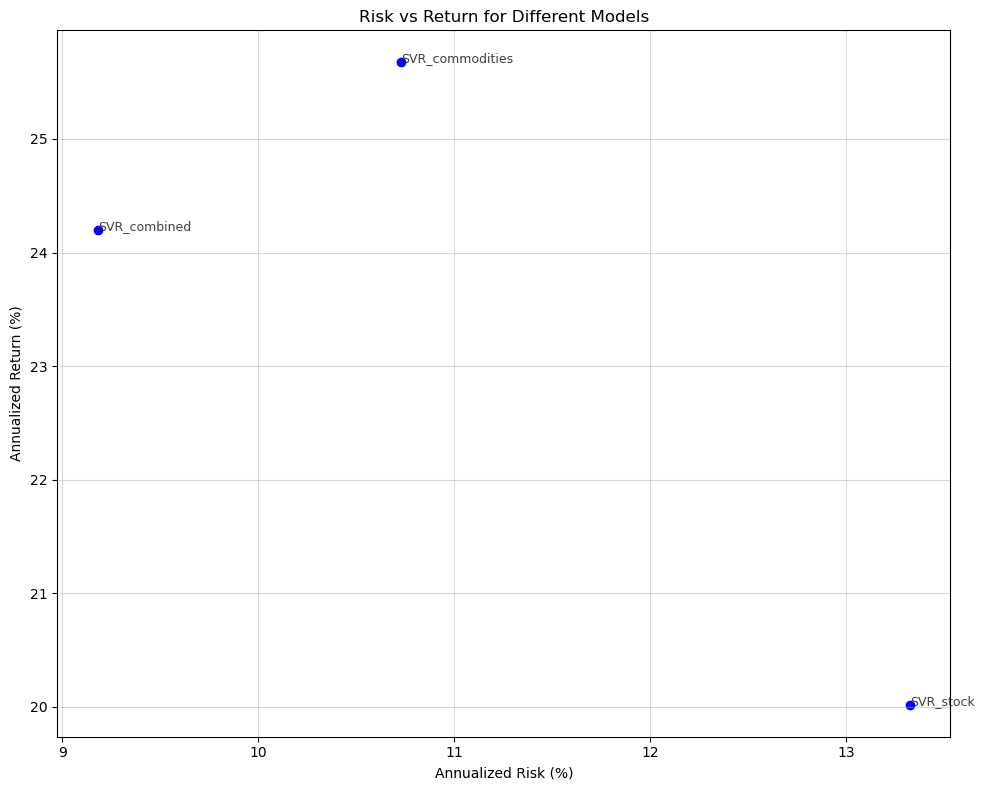

In [113]:
fig, ax = plt.subplots(figsize=(10, 8))

# Scatter plot
ax.scatter(annualized_risks, annualized_returns, color='blue')

# Annotate each point with the model name
for i, model_name in enumerate(models):
    ax.annotate(model_name, (annualized_risks[i], annualized_returns[i]), fontsize=9, alpha=0.75)

# Titles and labels
ax.set_title('Risk vs Return for Different Models')
ax.set_xlabel('Annualized Risk (%)')
ax.set_ylabel('Annualized Return (%)')

# Display the plot
plt.grid(True, alpha=0.5)
plt.tight_layout()
plt.show()